# Итоговое задание №2. Прогнозирование конечных свойств новых материалов (композиционных материалов)
На входе имеются данные о начальных свойствах компонентов композиционных материалов (количество связующего, наполнителя, температурный режим отверждения и т.д.). На выходе необходимо спрогнозировать ряд конечных свойств получаемых композиционных материалов. 

Предсказание (из семинара 22): 
* модуль упругости при растяжении
* прочности при растяжении
* cоотношение матрица-наполнитель

Предсказание (из итогового вебинара 26.11.2022):
* модуль упругости при растяжении
* прочности при растяжении

# Регрессия K-ближайших соседей

загружаем датасет

In [26]:
import numpy as np
import pandas as pd

In [27]:
# считывание данных из файла
def load_simple_df(full_nm_str):
    sdf = pd.read_csv('../data/interim/'+full_nm_str+'.csv', sep=';',index_col=0) # Загрузка и создание датафрейма из csv файла
    return sdf

#считывание всех наборов для одного из целевых показателей
def load_data(nm_str):
    x_train = load_simple_df('X_train_'+nm_str)
    y_train = load_simple_df('y_train_'+nm_str)
    x_test = load_simple_df('X_test_'+nm_str)
    y_test=load_simple_df('y_test_'+nm_str)
    x_val=load_simple_df('X_val_'+nm_str)
    y_val=load_simple_df('y_val_'+nm_str)
    return (x_train, y_train, x_test, y_test, x_val, y_val)

Регрессия k-ближайших соседей

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

In [29]:
# тренировка модели Линейной регрессии
def try_knn(x_train, y_train, x_val, y_val):
    knr_model = KNeighborsRegressor()
    neigh_params = {'n_neighbors' : range(1, 101, 1),
                    'weights' : ['uniform', 'distance'],
                    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
    GSCV_neigh = GridSearchCV(knr_model, neigh_params, n_jobs=-1, cv=10)   
    GSCV_neigh.fit(x_train, y_train)
    neigh = GSCV_neigh.best_estimator_
    
    MSE = mean_squared_error(y_val, neigh.predict(x_val))
    R2 = r2_score(y_val, neigh.predict(x_val))

    return (MSE, R2, neigh)
    

In [30]:
#запуск модели линейной регрессии и вычисление метрик
def fit_knr(nm_file_str, nm_error_df_str):
    #считываем данные из файлов
    x_train_df = pd.DataFrame()
    y_train_df = pd.DataFrame()
    x_test_df = pd.DataFrame()
    y_test_df = pd.DataFrame()
    x_val_df = pd.DataFrame()
    y_val_df = pd.DataFrame()

    (x_train_df, y_train_df, x_test_df, y_test_df, x_val_df, y_val_df) = load_data(nm_file_str)

    #обучаем модель
    (MSE, R2, prediction_y_val_knr) = try_knn(x_train_df, y_train_df, x_val_df, y_val_df)
    neigh_errors = pd.DataFrame({'model_name':'KNeighborsRegressor',
                              'target_var':[nm_error_df_str],
                              'MSE':[MSE],
                              'R2':[R2]})
    return (neigh_errors, x_val_df, y_val_df, prediction_y_val_knr)

In [31]:
#визуализация
import matplotlib.pyplot as plt

def actual_and_predicted_plot(orig, predict, var, model_name):
    plt.figure(figsize=(17,5))
    plt.title(f'Валидационные и прогнозные значения: {model_name}')
    plt.plot(orig, label='Валидация')
    plt.plot(predict, label='Прогноз')
    plt.legend(loc='best')
    plt.ylabel(var)
    plt.xlabel('Количество наблюдений')
    plt.show()

Для каждой характеристики запускаем последовательно обучение моделей

In [32]:
#датасет со значениями ошибок
errors_df = pd.DataFrame(columns=['target_var','model_name','MSE','R2'])

(fit_errors, x_val_elastic, y_val_elastic, y_val_elastic_predict) = fit_knr('elastic', 'Модуль упругости при растяжении, ГПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
(fit_errors, x_val_strength, y_val_strength, y_val_strength_predict) = fit_knr('strength', 'Прочность при растяжении, МПа')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
(fit_errors, x_val_matrix, y_val_matrix, y_val_matrix_predict) = fit_knr('matrix', 'Соотношение матрица-наполнитель')
errors_df = pd.concat([errors_df, fit_errors], ignore_index=True)
errors_df

,target_var,model_name,MSE,R2
0,"Модуль упругости при растяжении, ГПа",KNeighborsRegressor,0.029241,-0.018622
1,"Прочность при растяжении, МПа",KNeighborsRegressor,0.031151,-0.024620
2,Соотношение матрица-наполнитель,KNeighborsRegressor,0.027915,-0.019077


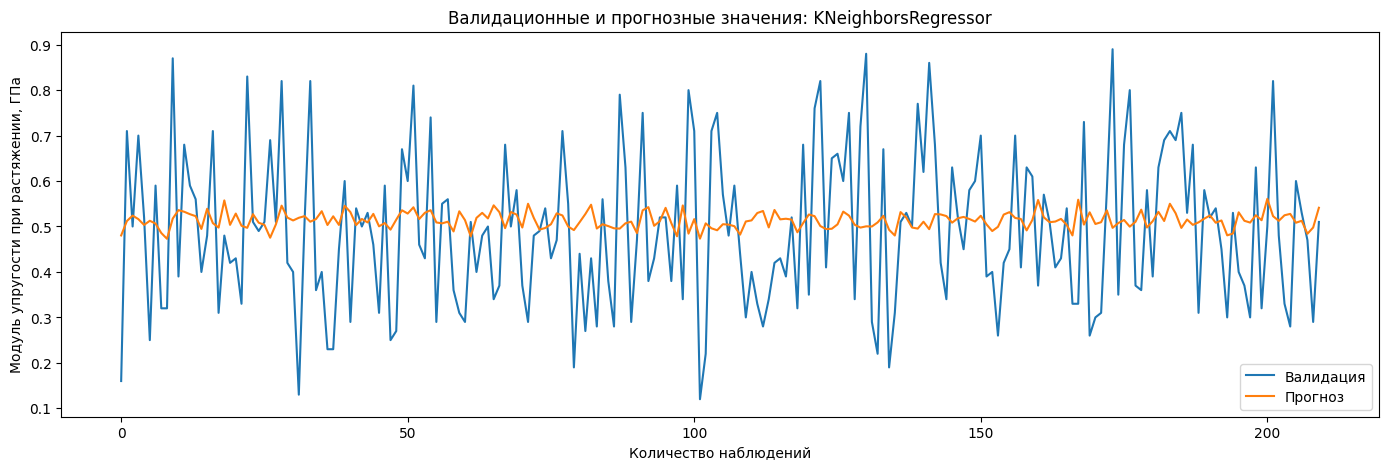

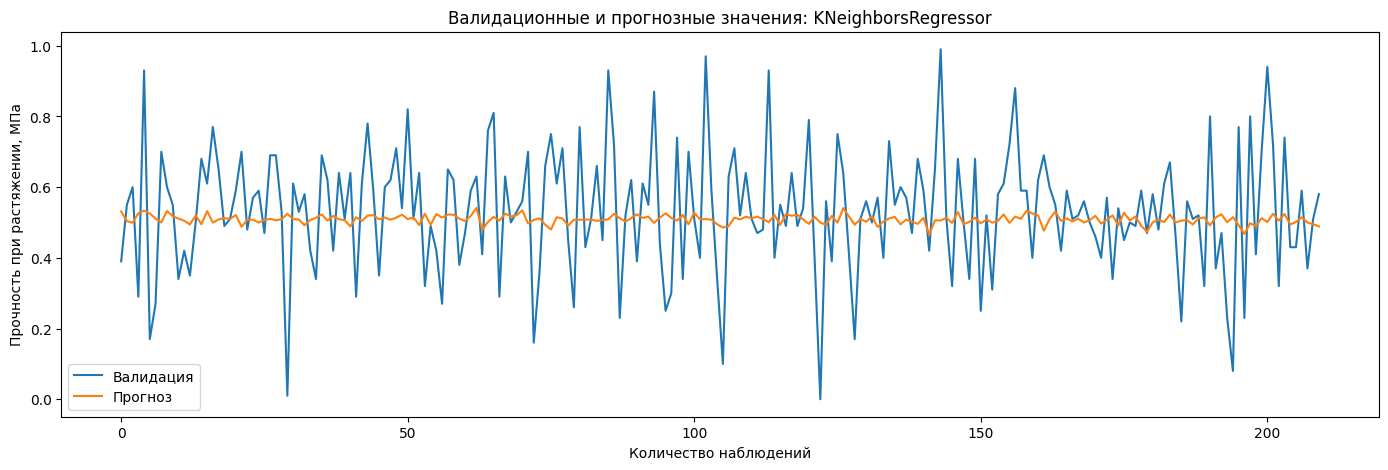

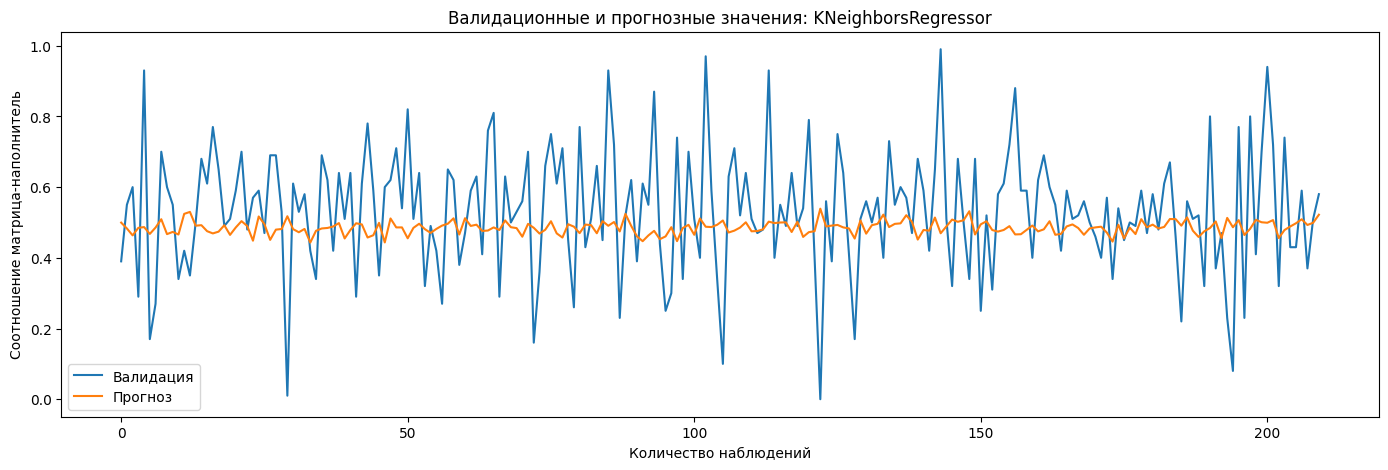

In [39]:
actual_and_predicted_plot(y_val_elastic.values,
                            y_val_elastic_predict.predict(x_val_elastic), 
                            'Модуль упругости при растяжении, ГПа',
                            'KNeighborsRegressor')
actual_and_predicted_plot(y_val_strength.values,
                            y_val_strength_predict.predict(x_val_strength), 
                            'Прочность при растяжении, МПа', 
                            'KNeighborsRegressor')
actual_and_predicted_plot(y_val_strength.values,
                            y_val_matrix_predict.predict(x_val_matrix), 
                            'Соотношение матрица-наполнитель', 
                            'KNeighborsRegressor')

Не подходящий метод для прогнозирования